In [1]:
from basic_utils import *

KeyboardInterrupt: 

In [2]:
class MultiCity_Cycle_Dataset(Dataset):
    def __init__(self):
        
        train_set = set()
        self.img_train_PM25, self.img_test_PM25 = [], []
        self.PM25, self.PM25_train, self.PM25_test = [], [], []
        
        self.train, self.test = [], []
        
        holdout = ['Shadipur', 'North_Campus', 'R_K_Puram', 'Sector116', 'Sirifort', 'Patparganj', 'CRRI_MTR_Rd', 'Sector125', 
               'Major_Dhyan_Chand_National_Stadium', 'Aya_Nagar', 'NSIT_Dwarka', 'Sri_Aurobindo_Marg', 'Bawana', 'Loni', 
               'Sector1', 'Narela', 'Dwarka_Sector_8', 'Mundka', 'Sanjay_Nagar', 'ITO', 'Jahangirpuri', 'Alipur', 'Ashok_Vihar', 
               'Sonia_Vihar', 'New_Collectorate', 'Okhla_Phase2', 'Pusa_IMD']

        with open('/datacommons/carlsonlab/srs108/old/ol/Delhi_clean.pkl', "rb") as fp:  
            images = pkl.load(fp)
            for data_point in tqdm(images, position=0, leave=True): 
                self.PM25.append(data_point['PM25'])

                if data_point['Station_index'] not in holdout:
                    train_set.add(data_point['Station_index'])
            train_set = sorted(list(train_set))

            for data_point in images:
                if data_point['Station_index'] in train_set:
                    self.train.append(tuple((data_point['Image'], data_point['PM25'])))
#                     self.img_train_PM25.append(data_point['Image'])
#                     self.PM25_train.append(data_point['PM25'])

                elif data_point['Station_index'] in holdout:
                    self.test.append(tuple((data_point['Image'][:,:,:3], data_point['PM25'])))
        
#                     self.img_test_PM25.append(data_point['Image'])
#                     self.PM25_test.append(data_point['PM25'])

        #Only adding to training
        with open('/datacommons/carlsonlab/srs108/old/ol/Lucknow.pkl', "rb") as fp:  
            images = pkl.load(fp)
            for data_point in tqdm(images):
                for station in data_point:
                    self.test.append(tuple((station['Image'][:,:,:3], station['PM'])))
#                     self.PM25_train.append(station['PM'])
#                     self.img_train_PM25.append(station['Image'][:,:,:3])
                        
                    
#         with open('/datacommons/carlsonlab/srs108/old/ol/Mumbai.pkl', "rb") as fp:
#             images = pkl.load(fp)
#             for data_point in tqdm(images):
#                 for station in data_point:
#                     self.test.append(tuple((station['Image'][:,:,:3], station['PM'])))
# #                     self.PM25_test.append(station['PM'])
# #                     self.img_test_PM25.append(station['Image'][:,:,:3])
        
        self.test = random.choices(self.test, k=len(self.train))

        
    def __len__(self): return len(self.train)
        
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            

        transform  = transforms.Compose([
                            transforms.ToPILImage(),
                            transforms.CenterCrop(size=224),
                            transforms.Pad(16),
                            transforms.ToTensor()])
 
        sample = {
        'source img': transform(self.train[idx][0]),
        'source pm' : self.train[idx][1],
        'target img': transform(self.test[idx][0]),
        'target_PM' : self.test[idx][1]} 
        return sample
       

In [3]:
x = MultiCity_Cycle_Dataset()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.


KeyboardInterrupt



In [ ]:
tr, te = train_test_split(x,test_size=0.2, random_state=611)

In [ ]:
dataloader = DataLoader(tr,batch_size=1, shuffle=True)
testloader = DataLoader(x, batch_size = 1)

In [ ]:
criterion_GAN = nn.BCEWithLogitsLoss().to(device) #this is different from phase two, it was MSE...?
criterion_cycle = torch.nn.L1Loss().to(device)
criterion_identity = torch.nn.L1Loss().to(device)
criterion_PM = torch.nn.MSELoss().to(device)

In [ ]:
input_shape = (channels, img_height, img_width) # (3,256,256)
n_residual_blocks = 6 # suggested default, number of residual blocks in generator


generator_checkpoint     = torch.load('/datacommons/carlsonlab/srs108/cycle/saved_models/Luck_Del_Mum_Gen.pt')
discriminator_checkpoint = torch.load('/datacommons/carlsonlab/srs108/cycle/saved_models/Luck_Del_Mum_Disc.pt')

G_AB = GeneratorResNet(input_shape, n_residual_blocks)
G_AB.load_state_dict(generator_checkpoint['G_AB'])
G_BA = GeneratorResNet(input_shape, n_residual_blocks)
G_BA.load_state_dict(generator_checkpoint['G_BA'])

G_AB.to(device)
G_BA.to(device)

D_A = Discriminator(input_shape)
D_A.load_state_dict(discriminator_checkpoint['D_A'])
D_B = Discriminator(input_shape)
D_B.load_state_dict(discriminator_checkpoint['D_B'])

D_A.to(device)
D_B.to(device)

C_A = Multi_City_CNN()
C_A.load_state_dict(torch.load('/datacommons/carlsonlab/srs108/cycle/saved_models/rerun.pt'))
for param in C_A.parameters():
    param.requires_grad = True #True=finetune
        
C_A.to(device)
print()


In [7]:
optimizer_G = torch.optim.Adam(
    itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=lr, betas=(b1,b2)
)

optimizer_D = torch.optim.Adam(
    itertools.chain(D_A.parameters(), D_B.parameters()), lr=lr/2, betas=(b1,b2)
)

optimizer_C_A = torch.optim.Adam(
    C_A.parameters(), lr=1e-3, betas=(b1, b2)
)

In [7]:
def sample_images(city1, city2, dataloader, e, i, show = False, save=False):
    source = next(iter(dataloader))
    G_AB.eval()
    G_BA.eval()
    real_A = source['source img'].type(Tensor)
    fake_B = G_AB(real_A).detach()
    real_B = source['target img'].type(Tensor)
    fake_A = G_BA(real_B).detach()

    recon_A = G_BA(fake_B).detach()
    recon_B = G_AB(fake_A).detach()

    real_A = make_grid(real_A, nrow=5, normalize=True, scale_each=True, padding=1)
    fake_B = make_grid(fake_B, nrow=5, normalize=True, scale_each=True, padding=1)
    real_B = make_grid(real_B, nrow=5, normalize=True, scale_each=True, padding=1)
    fake_A = make_grid(fake_A, nrow=5, normalize=True, scale_each=True, padding=1)
    recon_A = make_grid(recon_A, nrow=5, normalize=True, scale_each=True, padding=1)
    recon_B = make_grid(recon_B, nrow=5, normalize=True, scale_each=True, padding=1)
    
    # Set individual titles
    titles = [f'Real {city1}', f'Fake {city1}', f'Recon {city1}', f'Real {city2}', f'Fake {city2}', f'Recon {city2}']
    
    plt.figure(figsize=(12, 9))
    plt.subplots_adjust(left=0.02, right=0.98, top=0.98, bottom=0.02, wspace=0.02, hspace=0.02)  # Adjust spacing

    for index, grid in enumerate([real_A, fake_B, recon_A, real_B, fake_A, recon_B]):
        plt.subplot(1, 6, index+1)
        plt.imshow(grid.cpu().permute(1, 2, 0))
        plt.title(titles[index])
        plt.axis('off')

    if save:
        plt.savefig(os.path.join('Figure_PDFs', f'epoch_{str(e+1)}_iter{str(i+1)}.png'), bbox_inches='tight', pad_inches=0, facecolor='white')
    
    if show:
        plt.show()
    plt.close();

In [10]:
history = {'epoch':[],'G_loss':[],'adv_loss': [],'cyc_loss': [], 'idt_loss': [], 'D_loss':[],'pm_target_loss':[],  'pm_source_loss':[], 'batch':[]}
best_D_loss = 1e6
best_G_loss = 1e6
best_sem_loss = 1e7
pm_saver = {'epoch':[],'predict_from_source':[], "predict_from_target":[], "predict_from_fake_targ":[], "predict_from_fake_source":[], "pm_source_label":[], "pm_target_label":[], "predict_recon_source":[], "predict_recon_targ":[]}
epoch = 0 
n_epochs = 100

for epoch in range(epoch, n_epochs):
    for i, batch in enumerate(tqdm(dataloader)):
        # Set model input
        real_A = batch['source img'].type(Tensor)
        real_B = batch['target img'].type(Tensor)
        lbl_A = batch['source pm'].type(Tensor)
        lbl_B = batch['target_PM'].type(Tensor)
        
        fake_B = G_AB(real_A)
        fake_A = G_BA(real_B)

        recov_A = G_BA(fake_B)
        recov_B = G_AB(fake_A)
        
        #maybe try separate instances of C_A
        pm_from_real_source = C_A(real_A).squeeze(1)
        pm_from_real_target = C_A(real_B).squeeze(1)
        
        pm_from_fake_target = C_A(fake_B.detach()).squeeze(1)
        pm_from_fake_source = C_A(fake_A.detach()).squeeze(1)
        
        pm_from_recon_source = C_A(recov_A.detach()).squeeze(1)
        pm_from_recon_target = C_A(recov_B.detach()).squeeze(1)
        
        # Adversarial ground truths
        valid = Tensor(np.ones((real_A.size(0), *D_A.output_shape))) 
        fake = Tensor(np.zeros((real_A.size(0), *D_A.output_shape)))

        
# -----------------
# Train C_A
# -----------------
        optimizer_C_A.zero_grad()
        C_A.train()
        
        loss_sem1 = criterion_PM(pm_from_real_source, lbl_A)
#         loss_sem2 = criterion_PM(pm_from_fake_target, lbl_A)
        loss_sem3 = criterion_PM(pm_from_recon_source, lbl_A)
        
        loss_sem4 = criterion_PM(pm_from_real_target, lbl_B)
#         loss_sem5 = criterion_PM(pm_from_fake_source, lbl_B)
        loss_sem6 = criterion_PM(pm_from_recon_target, lbl_B)

        
        loss_semS = (loss_sem1 + loss_sem3)/2
        loss_semT = (loss_sem4  + loss_sem6)/2
        loss_sem = (loss_semS + loss_semT)/2
        
        loss_sem.backward()
        optimizer_C_A.step()

        if epoch == 99:
            pm_saver['epoch'].append(epoch+1)
            pm_saver['predict_from_source'].append(pm_from_real_source.item())
            pm_saver['predict_from_target'].append(pm_from_real_target.item())
            pm_saver['predict_from_fake_targ'].append(pm_from_fake_target.item())
            pm_saver['predict_from_fake_source'].append(pm_from_fake_source.item())
            pm_saver['pm_source_label'].append(lbl_A.item())
            pm_saver['pm_target_label'].append(lbl_B.item())
            pm_saver['predict_recon_source'].append(pm_from_recon_source.item())
            pm_saver['predict_recon_targ'].append(pm_from_recon_target.item())


# -----------------
# Train Generators ;;No backwards run in phase 3;;
# -----------------
        G_AB.train() # train mode
        G_BA.train() # train mode
        
        optimizer_G.zero_grad() # Integrated optimizer(G_AB, G_BA)
        
        # Identity Loss
        loss_id_A = criterion_identity(G_BA(real_A), real_A) # If you put A into a generator that creates A with B,
        loss_id_B = criterion_identity(G_AB(real_B), real_B) # then of course A must come out as it is.
                                                             # Taking this into consideration, add an identity loss that simply compares 'A and A' (or 'B and B').
        loss_identity = (loss_id_A + loss_id_B)/2
        
        # GAN Loss
        loss_GAN_AB = criterion_GAN(D_B(fake_B), valid) # tricking the 'fake-B' into 'real-B'
        loss_GAN_BA = criterion_GAN(D_A(fake_A), valid) # tricking the 'fake-A' into 'real-A'
        
        loss_GAN = (loss_GAN_AB + loss_GAN_BA)/2
        
        # Cycle Loss
        loss_cycle_A = criterion_cycle(recov_A, real_A) # Reduces the difference between the restored image and the real image
        
        loss_cycle_B = criterion_cycle(recov_B, real_B)
        
        loss_cycle = (loss_cycle_A + loss_cycle_B)/2
        

# ------> Total Loss
        loss_G = loss_GAN + (15.0*loss_cycle) + (5.0*loss_identity) # multiply suggested weight(default cycle loss weight : 10, default identity loss weight : 5)
        
        # Semantic Loss
        if (i+1) % 1000 ==0:
            print(f'pm from real source: {round(pm_from_real_source.item(),4)}\tpm from fake target: {round(pm_from_fake_target.item(),4)}\t pm label source: {round(lbl_A.item(),2)}')
            print(f'pm from real target: {round(pm_from_real_target.item(),4)}\tpm from fake source: {round(pm_from_fake_source.item(),4)}\t pm label target: {round(lbl_B.item(),2)}\n')
        loss_sem_AB = criterion_PM(pm_from_fake_target, lbl_A)
        loss_sem_BA = criterion_PM(pm_from_fake_source, pm_from_real_target)
        
        loss_G += loss_sem_AB + loss_sem_BA
        
#         loss_G.backward()
        optimizer_G.step()
        
# -------------------------------------------
# Train Discriminator A and Discriminator B ;;No backwards run in phase 3;;
# -------------------------------------------
        optimizer_D.zero_grad()
        D_A.train()
        D_B.train()
        loss_real = criterion_GAN(D_A(real_A), valid) # train to discriminate real images as real
        loss_fake = criterion_GAN(D_A(fake_A.detach()), fake) # train to discriminate fake images as fake
        loss_D_A = (loss_real + loss_fake)/2
#         loss_D_A.backward()

        loss_real = criterion_GAN(D_B(real_B), valid) # train to discriminate real images as real
        loss_fake = criterion_GAN(D_B(fake_B.detach()), fake) # train to discriminate fake images as fake
        loss_D_B = (loss_real + loss_fake)/2
#         loss_D_B.backward()
        
# ------> Total Loss
        loss_D = (loss_D_A + loss_D_B)/2
        optimizer_D.step()
        


# -----------------
# Model Saving
# -----------------    
            
        if loss_sem <= best_sem_loss:
            print(f'loss improved on epoch {epoch+1}: {loss_sem.item()}')
            best_sem_loss = loss_sem
            torch.save({'C_A': C_A.state_dict()}, '/datacommons/carlsonlab/srs108/cycle/saved_models/sem_model_updated.pt')
        
        
# -----------------
# Show Progress
# -----------------

        if (i+1) % 1000 == 0:
            with torch.no_grad():
#                 sample_images('Delhi', 'Lucknow',dataloader, epoch, i, show = False, save = False)
                sample_images('Delhi/Lucknow', 'Mumbai', val_dataloader, epoch, i, show = False, save = True)

                print('[Epoch %d/%d] [Batch %d/%d]'
                        %(epoch+1,n_epochs,       # [Epoch -]
                          i+1,len(dataloader),   # [Batch -]
                     ))
            
            history['G_loss'].append(loss_G.item())
            history['D_loss'].append(loss_D.item())
            history['batch'].append(i+1)
            history['epoch'].append(epoch+1)
            history['adv_loss'].append(loss_GAN.item())
            history['cyc_loss'].append(loss_cycle.item())
            history['idt_loss'].append(loss_identity.item())
            history['pm_source_loss'].append(loss_semS.item())
            history['pm_target_loss'].append(loss_semT.item())


loss improved on epoch 1: 979.0499877929688
loss improved on epoch 1: 99.21441650390625
loss improved on epoch 1: 47.14607238769531
loss improved on epoch 1: 46.76369857788086
loss improved on epoch 1: 21.98698616027832
pm from real source: 66.0089	pm from fake target: 64.6006	 pm label source: 119.03
pm from real target: 65.9331	pm from fake source: 60.6478	 pm label target: 13.36

[Epoch 1/100] [Batch 1000/10586]
loss improved on epoch 1: 21.084550857543945
loss improved on epoch 1: 7.559575080871582
pm from real source: 60.2184	pm from fake target: 54.8361	 pm label source: 111.81
pm from real target: 54.7461	pm from fake source: 57.8558	 pm label target: 62.36

[Epoch 1/100] [Batch 2000/10586]
pm from real source: 63.9619	pm from fake target: 59.7749	 pm label source: 50.36
pm from real target: 64.5546	pm from fake source: 62.0268	 pm label target: 64.61

[Epoch 1/100] [Batch 3000/10586]
pm from real source: 89.9298	pm from fake target: 69.0079	 pm label source: 62.46
pm from real 

KeyboardInterrupt: 

In [ ]:
pms = pd.DataFrame(pm_saver)
pms.to_csv('predicted_pms.csv', index=False)

In [ ]:
df = pd.DataFrame(history)
df.to_csv('history.csv', index=False)

In [9]:
sem_model_check = torch.load('/datacommons/carlsonlab/srs108/cycle/saved_models/sem_model_updated.pt')
C_B = Multi_City_CNN()
C_B.load_state_dict(sem_model_check['C_A'])
C_B.to(device)
print()

In [10]:
test_pm = {'predict_from_source':[], "predict_from_target":[], "predict_from_fake_targ":[], "predict_from_fake_source":[], "pm_source_label":[], "pm_target_label":[], "predict_recon_source":[], "predict_recon_targ":[]}

with torch.no_grad():
    for i, batch in enumerate(tqdm(testloader)):
        
        real_A = batch['source img'].type(Tensor)
        real_B = batch['target img'].type(Tensor)
        lbl_A = batch['source pm'].type(Tensor)
        lbl_B = batch['target_PM'].type(Tensor)

        fake_B = G_AB(real_A)
        fake_A = G_BA(real_B)

        recov_A = G_BA(fake_B)
        recov_B = G_AB(fake_A)

        #maybe try separate instances of C_A
        pm_from_real_source = C_B(real_A).squeeze(1)
        pm_from_real_target = C_B(real_B).squeeze(1)

        pm_from_fake_target = C_B(fake_B.detach()).squeeze(1)
        pm_from_fake_source = C_B(fake_A.detach()).squeeze(1)

        pm_from_recon_source = C_B(recov_A.detach()).squeeze(1)
        pm_from_recon_target = C_B(recov_B.detach()).squeeze(1)
        
        
#         loss_sem1 = criterion_PM(pm_from_real_source, lbl_A)
#         loss_sem2 = criterion_PM(pm_from_fake_target, lbl_A)
#         loss_sem3 = criterion_PM(pm_from_recon_source, lbl_A)
        
#         loss_sem4 = criterion_PM(pm_from_real_target, lbl_B)
#         loss_sem5 = criterion_PM(pm_from_fake_source, lbl_B)
#         loss_sem6 = criterion_PM(pm_from_recon_target, lbl_B)

        test_pm['predict_from_source'].append(pm_from_real_source.item())
        test_pm['predict_from_target'].append(pm_from_real_target.item())
        test_pm['predict_from_fake_targ'].append(pm_from_fake_target.item())
        test_pm['predict_from_fake_source'].append(pm_from_fake_source.item())
        test_pm['pm_source_label'].append(lbl_A.item())
        test_pm['pm_target_label'].append(lbl_B.item())
        test_pm['predict_recon_source'].append(pm_from_recon_source.item())
        test_pm['predict_recon_targ'].append(pm_from_recon_target.item())

#                 sample_images('Delhi', 'Lucknow',dataloader, epoch, i, show = False, save = False)
#     sample_images('Delhi/Lucknow', 'Mumbai', testloader, epoch, i, show = True, save = False)


In [26]:
# pms = pd.DataFrame(test_pm)
# pms.to_csv('test_pms.csv', index=False)

In [11]:
df = pd.DataFrame(test_pm)
source_prediction= df['predict_from_source'].tolist()
source_label = df['pm_source_label'].tolist()

In [10]:
df = pd.read_csv('/datacommons/carlsonlab/srs108/cycle/phase_two/predicted_pms.csv')

In [12]:
df

,predict_from_source,predict_from_target,predict_from_fake_targ,predict_from_fake_source,pm_source_label,pm_target_label,predict_recon_source,predict_recon_targ
0,70.009567,24.366360,29.385859,33.682266,34.610001,101.430000,58.438225,22.626305
1,74.067902,17.527271,30.233044,18.392605,55.869999,92.769997,66.634148,40.848076
2,194.057968,92.585556,27.539545,125.840820,345.160004,129.259995,105.516838,60.385193
3,68.417824,93.563644,44.447628,121.248604,115.459999,72.599998,74.268112,80.552010
4,41.939194,69.200661,45.750767,18.385523,69.250000,59.669998,64.414276,29.370537
...,...,...,...,...,...,...,...,...
13600,50.613228,123.496552,40.556984,78.057816,71.110001,25.250000,33.863083,113.481087
13601,64.935989,66.930420,27.242336,79.536621,69.849998,70.720001,42.373680,81.237526
13602,72.893234,54.471832,15.990953,43.883621,102.440002,54.259998,61.831818,49.933731
13603,100.239708,87.881355,51.516090,89.888313,55.790001,100.339996,56.911934,58.695915


In [13]:
selected_columns = ['predict_from_target', 'predict_recon_targ']

row_mean_selected = df[selected_columns].mean(axis=1)

df['avg_pred_target_recon'] = row_mean_selected



In [17]:
source_prediction= df['predict_from_target'].tolist()
source_label = df['pm_target_label'].tolist()

In [18]:
def eval_stat(predictions, ground_truth):
    Rsquared, pvalue = stats.spearmanr(predictions, ground_truth)
    Rsquared_pearson, pvalue_pearson = stats.pearsonr(predictions, ground_truth)
    return Rsquared, pvalue, Rsquared_pearson, pvalue_pearson


def plot_result(y_pred, y_true, Rsquared, pvalue, Rsquared_pearson, pvalue_pearson, plot_label="train", save=True, 
                fig_name="", lower_bound=0, upper_bound=100, spatial_R=-1):
    plt.clf()
    fig, ax = plt.subplots(figsize=(6, 5))
    data = pd.DataFrame(data={'y_true': y_true, 'y_pred': y_pred})
    ax = sns.histplot(data, x='y_true', y='y_pred', cbar=True, color='purple')
    ax.plot([lower_bound, upper_bound], [lower_bound, upper_bound], 'k--', lw=1)
    ax.set_xlabel('True $PM_{2.5}$ ($\mu $g m$^{-3}$)', size = 20)
    ax.set_ylabel('Predicted $PM_{2.5}$ ($\mu $g m$^{-3}$)', size = 20)
    ax.tick_params(labelsize = 15)
    ax.text(0.02, 0.98, 'Spearman r = '+ str(round(Rsquared,2)), ha='left', va='top', color='black', weight='roman', transform=ax.transAxes)
    ax.text(0.02, 0.94, 'Spearman p-value = '+ str(round(pvalue,2)), ha='left', va='top', color='black', weight='roman', transform=ax.transAxes)
    ax.text(0.02, 0.90, 'Pearson r = '+ str(round(Rsquared_pearson,2)), ha='left', va='top', color='black', weight='roman', transform=ax.transAxes)
    ax.text(0.02, 0.86, 'Pearson p-value = '+ str(round(pvalue_pearson,3)), ha='left', va='top', color='black', weight='roman', transform=ax.transAxes)
    ax.text(0.02, 0.82, 'RMSE = '+ str(round(np.sqrt(metrics.mean_squared_error(y_true, y_pred)),2)), ha='left', va='top', color='black', weight='roman', transform=ax.transAxes)
    ax.text(0.02, 0.78, 'MAE = '+ str(round(metrics.mean_absolute_error(y_true, y_pred),2)), ha='left', va='top', color='black', weight='roman', transform=ax.transAxes)
    ax.text(0.02, 0.74, '% error = '+ str(round(metrics.mean_absolute_error(y_true, y_pred)/np.mean(y_true)*100,1))+'%', ha='left', va='top', color='black', weight='roman', transform=ax.transAxes)
    if spatial_R != -1:
        ax.text(0.02, 0.70, 'Spatial Pearson r = ' + str(round(spatial_R, 2)), ha='left', va='top', color='black', weight='roman', fontsize=16, transform=ax.transAxes)
    if plot_label == "train":
        ax.set_title('Training')
#         ax.text(0.65, 0.10, 'training dataset', bbox=dict(facecolor='grey', alpha=0.9), ha="left", va="top", color='black', weight='roman', fontsize=20, transform=ax.transAxes)
    else:
        ax.set_title('Testing')
#         ax.text(0.65, 0.10, 'test dataset', bbox=dict(facecolor='grey', alpha=0.9), ha="left", va="top", color='black', weight='roman', fontsize=20, transform=ax.transAxes)
        
    # plt.gca().set_aspect('equal', adjustable='box')
    if save:
        plt.savefig(PROJECT_ROOT_DIR+'/'+PROJECT_SAVE_DIR+'/'+fig_name+'.pdf', dpi=300)
    pass
    plt.show()
    del data, ax
    return

<Figure size 432x288 with 0 Axes>

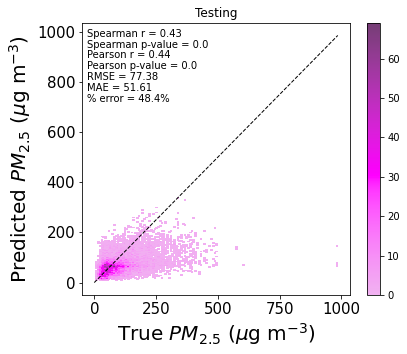

In [19]:
train_predictions_ = source_prediction
train_ground_truth_ = source_label
Rsquared, pvalue, Rsquared_pearson, pvalue_pearson = eval_stat(train_predictions_, train_ground_truth_)

plot_result(train_predictions_, train_ground_truth_, Rsquared, pvalue, Rsquared_pearson, pvalue_pearson, lower_bound=0, upper_bound=max(train_ground_truth_), 
            plot_label="testing",save = False,fig_name = 'train')

# Testing Target Domain

In [48]:
# selected_columns = ['predict_from_target', 'predict_recon_targ', 'predict_from_fake_source']

# row_mean_selected = df[selected_columns].mean(axis=1)

# df['avg_pred_target_recon'] = row_mean_selected



In [49]:
# source_prediction= df['avg_pred_target_recon'].tolist()
# source_label = df['pm_target_label'].tolist()

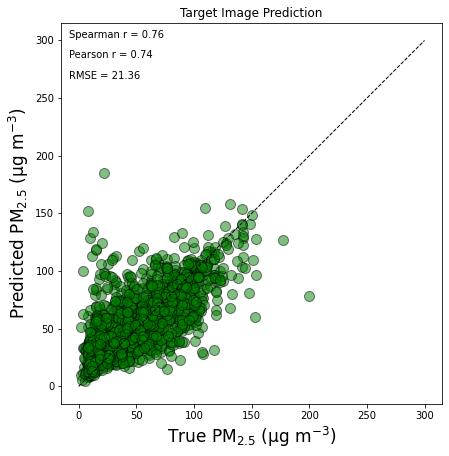

In [52]:
# train_predictions_ = source_prediction
# train_ground_truth_ = source_label
# Rsquared, pvalue, Rsquared_pearson, pvalue_pearson = eval_stat(train_predictions_, train_ground_truth_)

# plot_result(train_predictions_, train_ground_truth_, Rsquared, pvalue, Rsquared_pearson, pvalue_pearson, lower_bound=0, upper_bound=300,save = True , plot_title='Target Image Prediction', fig_name = 'target')